In [583]:
import numpy as np 
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA


In [584]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [969]:
file = "data/compiled_dataset_RSbivariate_without_controls_v7.xlsx"
data = pd.read_excel(file, header=[0,1])
patients = data[("participant", "participant")]

In [586]:
featuresFAL = ["fa_avg_ccmaj", "fa_avg_ccmin", "fa_avg_lifof", "fa_avg_lilf", "fa_avg_lslf", "fa_avg_lunc", "fa_avg_larc"]
featuresFAR = ["fa_avg_rifof", "fa_avg_rilf", "fa_avg_rslf", "fa_avg_runc", "fa_avg_rarc"]
FA_L = data["average_FA_values"][featuresFAL].fillna(0).values
FA_R = data["average_FA_values"][featuresFAR].fillna(data["average_FA_values"][featuresFAR].mean()).values
FA = pd.DataFrame(np.hstack((FA_L, FA_R)))

In [991]:
LS = data["lesion_size"]

GM = data["percent_spared_in_gray_matter"]
outputs = data[("behavioral", "wab_aq_bd")]

GM = GM[outputs > 20]
outputs = outputs[outputs > 20]
GM = GM.reset_index(drop=True)
outputs = outputs.reset_index(drop=True)
GM.head()

,L_PCG_spgm,L_SFG_spgm,L_MFG_spgm,L_IFGop_spgm,L_IFGtri_spgm,L_IFGorb_spgm,L_ROL_spgm,L_SMA_spgm,L_OLF_spgm,L_SFGmedial_spgm,...,L_ACCpre_spgm,L_ACCsup_spgm,L_Nacc_spgm,L_VTA_spgm,L_SNpc_spgm,L_SNpr_spgm,L_RedN_spgm,L_LC_spgm,L_RapheD_spgm,L_RapheM_spgm
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.952088,0.629179,1.000000,1.000000,1.0,...,1.0,1.0,1.0,1,1,1.000000,1,1,1,1
1,0.209870,0.981314,0.760595,0.076923,0.279272,0.630221,0.019270,0.867257,0.975352,1.0,...,1.0,1.0,1.0,1,1,0.924528,1,1,1,1
2,0.713345,0.998875,0.998667,0.955470,1.000000,0.982801,0.303553,1.000000,1.000000,1.0,...,1.0,1.0,1.0,1,1,1.000000,1,1,1,1
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.876518,1.000000,1.000000,1.0,...,1.0,1.0,1.0,1,1,1.000000,1,1,1,1
4,0.967102,1.000000,0.999778,0.858382,0.839399,0.611794,0.187247,1.000000,0.996564,1.0,...,1.0,1.0,1.0,1,1,1.000000,1,1,1,1


In [588]:
RS = data["restingstate_bivariate_correlations"]
outputs = data[("behavioral", "wab_aq_bd")]
RS.head()

,L_PCG_vs_L_SFG_RS,L_PCG_vs_L_MFG_RS,L_PCG_vs_L_IFGop_RS,L_PCG_vs_L_IFGtri_RS,L_PCG_vs_L_IFGorb_RS,L_PCG_vs_L_SMA_RS,L_PCG_vs_L_SFGmedial_RS,L_PCG_vs_L_OFGmedial_RS,L_PCG_vs_L_INS_RS,L_PCG_vs_L_ACCsub_RS,...,R_STG_vs_R_supTP_RS,R_STG_vs_R_MTG_RS,R_STG_vs_R_midTP_RS,R_STG_vs_R_ITG_RS,R_supTP_vs_R_MTG_RS,R_supTP_vs_R_midTP_RS,R_supTP_vs_R_ITG_RS,R_MTG_vs_R_midTP_RS,R_MTG_vs_R_ITG_RS,R_midTP_vs_R_ITG_RS
0,0.543186,0.497695,0.152697,0.259980,-0.156438,0.712619,0.596957,-0.170590,-0.355312,0.145493,...,0.546217,0.153739,0.019124,0.022608,0.270152,0.525271,0.216016,0.541292,0.457530,0.395838
1,0.313370,0.601738,0.339186,0.233801,-0.050403,0.652251,-0.113404,-0.142937,-0.164339,-0.102709,...,0.645402,0.324367,0.191559,0.005703,0.186094,0.295105,-0.086173,0.412700,0.250223,0.260219
2,0.391621,0.618420,0.027674,-0.160126,-0.153705,0.753853,0.267316,0.036468,-0.250165,-0.195247,...,0.256193,0.457535,-0.077202,-0.260306,0.630908,0.225479,-0.209545,0.342598,0.122615,0.383682
3,0.794464,1.030842,0.484294,0.292885,0.000207,0.796879,0.365608,-0.066698,-0.059420,-0.215839,...,0.436731,1.073141,0.270031,0.109994,0.417399,0.990068,0.284407,0.316269,0.351875,0.409332
4,0.160964,0.415125,0.611820,0.736273,0.138293,0.187224,-0.067151,-0.125181,0.144175,-0.033475,...,0.587701,0.099944,0.316862,-0.184790,0.284497,0.770493,0.008133,0.647340,0.494847,0.228414


In [629]:
WM = data["percent_spared_in_white_matter"]

In [964]:
# DBSCAN(eps=6, min_samples=3).fit(X_train)
# KMeans(n_clusters=4, random_state=0, n_init="auto")

# outputs = outputs.values.reshape(-1,1)
kf = KFold(n_splits= 55, shuffle=True)
n_clusters = 2
n_clusters2 = 2

mdepth = 5
val_MSE = []
dta  = GM
total_scores = []
total_preds = []
total_stds = []
fimportances = []

participant_indexes = []
participant_clusters = []
for i, (train_index, val_index) in enumerate(kf.split(dta)):

        X_train, y_train = dta.iloc[train_index,:], outputs[train_index]
        X_val, y_val = dta.iloc[val_index,:], outputs[val_index]
        participant_indexes.append(val_index[0])
                
        prediction = []    
        val_output = []
        stds = []
        feaimportances = []                

        # clustering = GaussianMixture(n_components=n_clusters,tol=1e-5, random_state=0).fit(X_train.values)
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train.values)
        # clustering = 

        train_clusters = clustering.predict(X_train)
        prediction_clusters = clustering.predict(X_val)


        for cluster in tqdm(range(n_clusters)):
                train_data = X_train[train_clusters==cluster]
                train_outputs = y_train[train_clusters==cluster]   
                                
                val_data = X_val[prediction_clusters==cluster]
                val_outputs = y_val[prediction_clusters==cluster]                
                
                clustering = KMeans(n_clusters=n_clusters2, random_state=0).fit(train_data.values)
                
                train_clusters2 = clustering.predict(train_data)
                
                if len(val_data) >= 1:
                        prediction_clusters2 = clustering.predict(val_data)
                        
                        for cluster2 in range(n_clusters2):
                                
                                regr = RandomForestRegressor(max_depth=mdepth, random_state=40 ) #, max_features = None)

                                cluster_data = train_data[train_clusters2==1]#cluster2]
                                cluster_outputs = train_outputs[train_clusters2==1]#cluster2]   
                                
                                scaler = MinMaxScaler()
                                cluster_outputs = scaler.fit_transform(cluster_outputs)
                                
                                cluster_val_data = val_data[prediction_clusters2==cluster2]
                                cluster_val_outputs = val_outputs[prediction_clusters2==cluster2]
                                                
                                predictor = RandomForestRegressor(max_depth=4, random_state=0)
                                
                                # clustering = KMeans(n_clusters=n_clusters2, random_state=0).fit(train_data.values)
                                # train_clusters2 = clustering.predict(train_data)
                                # prediction_clusters2 = clustering.predict(val_data)
                                        
                                if len(cluster_data) >= 1:
                                        regr = make_pipeline(StandardScaler(), predictor)
                                        regr.fit(cluster_data, cluster_outputs.ravel())
                                        featimportances = regr["randomforestregressor"].feature_importances_ 
                                        features = list(cluster_data.columns)
                                        
                                        
                                        importances = pd.DataFrame()
                                        importances["features"] = features 
                                        importances["features MDI importances"] = featimportances
                                
                                        feaimportances.append(importances)
                                
                                        std = np.std([tree.feature_importances_ for tree in regr["randomforestregressor"].estimators_], axis=0)
                                        stds += [std]
                                
                                if len(cluster_val_data)>=1:
                                        participant_clusters.append(cluster2)
                                        cluster_val_outputs = scaler.transform(cluster_val_outputs)
                                        vpreds = regr.predict(cluster_val_data)
                                        vpreds = vpreds.reshape(len(vpreds),1)
                                        vpreds = scaler.inverse_transform(vpreds)
                                        prediction += list(vpreds.flatten())
                                        
                                        vouts = scaler.inverse_transform(cluster_val_outputs).flatten()
                                        val_output += list(vouts)
                                
        
        total_preds.append(prediction[0])
        total_scores.append(val_output[0])    
        total_stds.append(stds)
        fimportances.append(feaimportances)
        val_MSE.append(mean_squared_error(prediction, val_output, squared=False))
        

print("validation MSEs are ")
print(val_MSE)   

total_scores = np.array(total_scores)
total_preds = np.array(total_preds)
 

100%|██████████| 2/2 [00:00<00:00, 11.89it/s]

validation MSEs are 
[2.0270000000000152, 26.391449999999992, 7.864583333333343, 1.4836666666666574, 10.717926190476192, 15.857302777777804, 7.657999999999987, 27.234329761904778, 43.300933333333276, 23.189249999999973, 27.058309523809527, 26.911120238095236, 13.872169047619067, 10.25699999999999, 7.341999999999999, 21.713029365079358, 3.7213388888888943, 0.3354999999999819, 23.863297619047614, 10.886931168831168, 56.929, 8.40491666666668, 6.137999999999991, 4.481166666666645, 43.978041666666684, 7.487000000000023, 0.7130000000000081, 29.409, 11.180944047619043, 13.00200000000001, 5.190906349206344, 8.433999999999997, 22.19135317460318, 1.216239285714309, 25.02526666666668, 2.437599999999975, 34.91915476190477, 13.739466666666686, 11.305000000000021, 7.121000000000009, 0.7585273809523656, 27.95129999999999, 1.4690000000000083, 12.040866666666673, 16.70820357142857, 7.522999999999996, 12.814511111111116, 34.32715595238095, 20.025035714285707, 5.152999999999992, 57.33198174603172, 13.450

In [993]:
# DBSCAN(eps=6, min_samples=3).fit(X_train)
# KMeans(n_clusters=4, random_state=0, n_init="auto")

outputs = outputs.values.reshape(-1,1)
n_clusters = 2
mdepth = 5
val_MSE = []

dta  = GM
ops = outputs

kf = KFold(n_splits= len(dta), shuffle=True)
total_scores = []
total_preds = []
total_stds = []
fimportances = []

participant_indexes = []
participant_clusters = []
for i, (train_index, val_index) in enumerate(kf.split(dta)):

        X_train, y_train = dta.iloc[train_index,:], ops[train_index]
        X_val, y_val = dta.iloc[val_index,:], ops[val_index]
        participant_indexes.append(val_index[0])
                
        prediction = []    
        val_output = []
        stds = []
        feaimportances = []                

        # clustering = GaussianMixture(n_components=n_clusters,tol=1e-5, random_state=0).fit(X_train.values)
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train.values)

        train_clusters = clustering.predict(X_train)
        prediction_clusters = clustering.predict(X_val)


        for cluster in tqdm(range(n_clusters)):
                regr = RandomForestRegressor(max_depth=mdepth, random_state=0 ) #, max_features = None)
                train_data = X_train[train_clusters==cluster]
                train_outputs = y_train[train_clusters==cluster]   
                
                scaler = MinMaxScaler()
                train_outputs = scaler.fit_transform(train_outputs)
                
                val_data = X_val[prediction_clusters==cluster]
                val_outputs = y_val[prediction_clusters==cluster]
                                
                predictor = RandomForestRegressor(max_depth=4, random_state=0)
                
                
                if len(train_data) >= 1:
                        regr = make_pipeline(StandardScaler(), predictor)
                        regr.fit(train_data, train_outputs.ravel())
                        featimportances = regr["randomforestregressor"].feature_importances_ 
                        features = list(train_data.columns)
                        
                        
                        importances = pd.DataFrame()
                        importances["features"] = features 
                        importances["features MDI importances"] = featimportances
                
                        feaimportances.append(importances)
                
                        std = np.std([tree.feature_importances_ for tree in regr["randomforestregressor"].estimators_], axis=0)
                        stds += [std]
                
                if len(val_data)>=1:
                        participant_clusters.append(cluster)
                        val_outputs = scaler.transform(val_outputs)
                        vpreds = regr.predict(val_data)
                        vpreds = vpreds.reshape(len(vpreds),1)
                        vpreds = scaler.inverse_transform(vpreds)
                        prediction += list(vpreds.flatten())
                        
                        vouts = scaler.inverse_transform(val_outputs).flatten()
                        val_output += list(vouts)
                        
        
        total_preds.append(prediction[0])
        total_scores.append(val_output[0])    
        total_stds.append(stds)
        fimportances.append(feaimportances)
        val_MSE.append(mean_squared_error(prediction, val_output, squared=False))
        

print("validation MSEs are ")
print(val_MSE)    

100%|██████████| 2/2 [00:00<00:00, 12.09it/s]

validation MSEs are 
[6.637719047619086, 1.7732950160950125, 28.830067884892877, 3.100580264180252, 7.580740476190456, 18.444775274725288, 6.583431024531038, 21.45526506157239, 10.905104761904752, 8.55334573996263, 29.035881868131867, 56.61905629925628, 9.664891486291495, 8.028268975795442, 3.8998550144300026, 13.808817279942282, 8.765435576351784, 10.928148434898432, 24.8756010989011, 0.10723928571428587, 10.824500414781298, 2.591714285714275, 4.903124997224978, 16.315163930513947, 0.9741172077922045, 25.32692182539681, 9.209492857142848, 23.14384713897209, 17.017026995227, 21.45699016816517, 19.788122405372405, 31.436638951489677, 27.743695238095228, 23.57037301587303, 34.338645418470435, 26.415091630591668, 16.513821664446667, 5.017679449553725, 9.518650904650897, 9.618144363136011, 6.749829761904792, 33.62972738095236, 16.590028493646898, 2.3570187408996333, 4.5060269480519395, 22.979747799422803, 13.247779761904823, 30.29576528136896, 6.608058730158746, 19.794986471861478, 3.98909

In [996]:
val_MSE = np.array(val_MSE)

print("Noneed Improvement data < 10 = ", len(val_MSE[val_MSE <= 10]), " -- mean = ", np.mean(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Noneed Improvement data between 10, 20 = ",len(temp), " --- mean = ", np.mean(temp))

print("Noneed Improvement data > 20 = ",len(val_MSE[val_MSE > 20]), "  -- mean = ", np.mean(val_MSE[val_MSE > 20]))

GM_scores = np.array(total_scores)
GM_preds = np.array(total_preds)

print(GM_scores[val_MSE > 20])
print(GM_preds[val_MSE > 20])

Noneed Improvement data < 10 =  25  -- mean =  5.921250882326136
Noneed Improvement data between 10, 20 =  12  --- mean =  15.34818965743544
Noneed Improvement data > 20 =  16   -- mean =  28.822082253847046
[92.  33.6 74.3 28.9 74.1 65.4 97.  76.2 89.  56.  88.9 25.2 57.6 97.
 40.  30.8]
[63.16993212 55.05526506 45.26411813 85.5190563  49.2243989  90.72692183
 73.85615286 54.74300983 57.56336105 83.74369524 65.32962698 59.53864542
 84.01509163 63.37027262 62.9797478  61.09576528]


# Tests on Rabbit-hole approach

In [948]:
dta = GM

val_MSE = np.array(val_MSE)
participant_clusters = np.array(participant_clusters)

print(participant_clusters[val_MSE > 20])
print(total_scores[val_MSE > 20])

# participant_indexes = np.array(participant_indexes)
# needImprovementIndexes = participant_indexes[val_MSE >= 10]
# NoneedImprovementIndexes = participant_indexes[val_MSE < 10]

# needImprovementPatients = dta.iloc[needImprovementIndexes, :]
# NoneedImprovementPatients = dta.iloc[NoneedImprovementIndexes, :]

# needImprovementOutputs = outputs[needImprovementIndexes]
# NoneedImprovementOutputs = outputs[NoneedImprovementIndexes]


# cluster1Data_indexes = participant_indexes[participant_clusters == 0]
# cluster1Data = dta.iloc[cluster1Data_indexes, :]
# cluster1Data_outputs = outputs[cluster1Data_indexes]


# cluster2Data_indexes = participant_indexes[participant_clusters == 1]
# cluster2Data = dta.iloc[cluster2Data_indexes, :]
# cluster2Data_outputs = outputs[cluster2Data_indexes]


[1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1]
[25.2 97.  88.9 13.  66.6 74.1 57.6 28.9 56.  76.2 82.8 74.3 30.8 92.
 89.  65.4 97.  11.7]


## On Need Improvement data

In [932]:
# DBSCAN(eps=6, min_samples=3).fit(X_train)
# KMeans(n_clusters=4, random_state=0, n_init="auto")

# outputs = outputs.values.reshape(-1,1)
n_clusters = 2
mdepth = 5

dta  = cluster1Data
ops = cluster1Data_outputs

kf = KFold(n_splits= len(dta), shuffle=True)

val_MSE = []
total_scores = []
total_preds = []
total_stds = []
fimportances = []

participant_indexes = []
participant_clusters = []
for i, (train_index, val_index) in enumerate(kf.split(dta)):

        X_train, y_train = dta.iloc[train_index,:], ops[train_index]
        X_val, y_val = dta.iloc[val_index,:], ops[val_index]
        participant_indexes.append(val_index[0])
                
        prediction = []    
        val_output = []
        stds = []
        feaimportances = []                

        # clustering = GaussianMixture(n_components=n_clusters,tol=1e-5, random_state=0).fit(X_train.values)
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train.values)

        train_clusters = clustering.predict(X_train)
        prediction_clusters = clustering.predict(X_val)


        for cluster in tqdm(range(n_clusters)):
                regr = RandomForestRegressor(max_depth=mdepth, random_state=0 ) #, max_features = None)
                train_data = X_train[train_clusters==cluster]
                train_outputs = y_train[train_clusters==cluster]   
                
                scaler = MinMaxScaler()
                train_outputs = scaler.fit_transform(train_outputs)
                
                val_data = X_val[prediction_clusters==cluster]
                val_outputs = y_val[prediction_clusters==cluster]
                                
                predictor = RandomForestRegressor(max_depth=4, random_state=0)
                
                
                if len(train_data) >= 1:
                        regr = make_pipeline(StandardScaler(), predictor)
                        regr.fit(train_data, train_outputs.ravel())
                        featimportances = regr["randomforestregressor"].feature_importances_ 
                        features = list(train_data.columns)
                        
                        
                        importances = pd.DataFrame()
                        importances["features"] = features 
                        importances["features MDI importances"] = featimportances
                
                        feaimportances.append(importances)
                
                        std = np.std([tree.feature_importances_ for tree in regr["randomforestregressor"].estimators_], axis=0)
                        stds += [std]
                
                if len(val_data)>=1:
                        participant_clusters.append(cluster)
                        val_outputs = scaler.transform(val_outputs)
                        vpreds = regr.predict(val_data)
                        vpreds = vpreds.reshape(len(vpreds),1)
                        vpreds = scaler.inverse_transform(vpreds)
                        prediction += list(vpreds.flatten())
                        
                        vouts = scaler.inverse_transform(val_outputs).flatten()
                        val_output += list(vouts)
                        
        
        total_preds.append(prediction[0])
        total_scores.append(val_output[0])    
        total_stds.append(stds)
        fimportances.append(feaimportances)
        val_MSE.append(mean_squared_error(prediction, val_output, squared=False))
        

print("validation MSEs are ")
print(val_MSE)    

100%|██████████| 2/2 [00:00<00:00, 13.40it/s]

validation MSEs are 
[23.447000000000003, 5.042153571428585, 2.610937698412698, 16.63200000000002, 30.39800000000001, 0.24342023809523994, 9.835220707070718, 28.986679365079368, 5.881856746031744, 6.828958730158718, 12.601990476190466, 3.215577777777767, 15.418349206349191, 9.224317063492052, 4.751309523809567, 5.112245238095241, 9.32629087301585, 1.2751369047618937, 9.787999999999997, 15.965341666666674, 25.63916507936507, 5.047503968253963]


In [928]:
val_MSE = np.array(val_MSE)

print("Noneed Improvement data < 10 = ", len(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Noneed Improvement data between 10, 20 = ",len(temp))

print("Noneed Improvement data > 20 = ",len(val_MSE[val_MSE > 20]))

RS_scores = np.array(total_scores)
RS_preds = np.array(total_preds)

print(RS_scores[val_MSE > 30])
print(RS_preds[val_MSE > 30])

Noneed Improvement data < 10 =  12
Noneed Improvement data between 10, 20 =  6
Noneed Improvement data > 20 =  15
[11.7 84.  66.6 28.9 13.  30.8]
[46.43916667 48.433      29.93525    83.50475833 67.98016667 63.61063333]


In [933]:
val_MSE = np.array(val_MSE)

print("Noneed Improvement data < 10 = ", len(val_MSE[val_MSE <= 10]), " -- mean = ", np.mean(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Noneed Improvement data between 10, 20 = ",len(temp), " --- mean = ", np.mean(temp))

print("Noneed Improvement data > 20 = ",len(val_MSE[val_MSE > 20]), "  -- mean = ", np.mean(val_MSE[val_MSE > 20]))

GM_scores = np.array(total_scores)
GM_preds = np.array(total_preds)

print(GM_scores[val_MSE > 30])
print(GM_preds[val_MSE > 30])

Noneed Improvement data < 10 =  14  -- mean =  5.584494931457431
Noneed Improvement data between 10, 20 =  4  --- mean =  15.154420337301588
Noneed Improvement data > 20 =  4   -- mean =  27.117711111111113
[52.8]
[83.198]


## On Noneed Improvement data

# Seperate Tests

## Resting state preds

In [694]:
val_MSE = np.array(val_MSE)
# < 10 - 16
# 10 > , < 20 - 10
# > 20 - 29

print("Resting state < 10 = ", len(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("resting state between 10, 20 = ",len(temp))

print("resting state > 20 = ",len(val_MSE[val_MSE > 20]))

RS_scores = np.array(total_scores)
RS_preds = np.array(total_preds)

print(RS_scores[val_MSE > 30])
print(RS_preds[val_MSE > 30])

Resting state < 10 =  16
resting state between 10, 20 =  10
resting state > 20 =  29
[28.9 97.  45.2 92.7 92.1 13.  11.7 82.8 87.2 30.8]
[62.07985635 57.98119325 75.22794048 54.02135714 61.96166812 54.43028333
 60.71709286 46.16742857 46.76998095 76.24916667]


### Feature Importances

In [695]:
# patientimportances = []
# totalpatientimportances = []
# for patient in range(55):
#     totalfeatures = []
#     for cluster in range(3):
#         if len(totalfeatures) == 0:
#             totalfeatures = fimportances[patient][cluster]
#         else:
#             # print("we here?")
#             totalfeatures["features MDI importances"] += fimportances[patient][cluster]["features MDI importances"]
            
#     totalfeatures["features MDI importances"] = totalfeatures["features MDI importances"]
#     total_features = totalfeatures.sort_values(by="features MDI importances", ascending=False)
#     patientimportances.append(total_features) 
    
#     if len(totalpatientimportances) == 0:
#         totalpatientimportances = totalfeatures
#     else:
#         totalpatientimportances["features MDI importances"] += totalfeatures["features MDI importances"]
    
# totalpatientimportances["features MDI importances"] = totalpatientimportances["features MDI importances"]/55
# totalpatientimportances = totalpatientimportances.sort_values(by="features MDI importances", ascending=False)
# totalpatientimportances
    
# RSFA = totalpatientimportances
# RSFA.head(10)

,features,features MDI importances
370,R_SFG_vs_R_midTP_RS,0.100580
348,R_PCG_vs_R_ITG_RS,0.039393
487,R_SFGmedial_vs_R_midTP_RS,0.036540
620,R_supTP_vs_R_midTP_RS,0.034715
545,R_ACCpre_vs_R_midTP_RS,0.034287
166,L_SFGmedial_vs_L_STG_RS,0.032794
61,L_MFG_vs_L_FUS_RS,0.030466
131,L_IFGorb_vs_L_MTG_RS,0.030149
449,R_IFGorb_vs_R_STG_RS,0.029527
527,R_ACCsub_vs_R_SMG_RS,0.023447


## GM preds

In [697]:
val_MSE = np.array(val_MSE)
# < 10 - 25
# 10 > , < 20 - 10
# > 20 - 20

print("Grey Matter < 10 = ", len(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Grey Matter between 10, 20 = ",len(temp))

print("Grey Matter > 20 = ",len(val_MSE[val_MSE > 20]))

GM_scores = np.array(total_scores)
GM_preds = np.array(total_preds)

print(GM_scores[val_MSE > 30])
print(GM_preds[val_MSE > 30])

Grey Matter < 10 =  25
Grey Matter between 10, 20 =  10
Grey Matter > 20 =  20
[89.  13.  66.6 97.  76.2 28.9 11.7 84.  30.8]
[56.50909048 61.68206667 26.716      60.21634167 40.853      77.30574444
 50.57068571 53.49208333 62.97119868]


### Feature Importances

In [698]:
patientimportances = []
totalpatientimportances = []
for patient in range(55):
    totalfeatures = []
    for cluster in range(3):
        if len(totalfeatures) == 0:
            totalfeatures = fimportances[patient][cluster]
        else:
            # print("we here?")
            totalfeatures["features MDI importances"] += fimportances[patient][cluster]["features MDI importances"]
            
    totalfeatures["features MDI importances"] = totalfeatures["features MDI importances"]
    total_features = totalfeatures.sort_values(by="features MDI importances", ascending=False)
    patientimportances.append(total_features) 
    
    if len(totalpatientimportances) == 0:
        totalpatientimportances = totalfeatures
    else:
        totalpatientimportances["features MDI importances"] += totalfeatures["features MDI importances"]
    
totalpatientimportances["features MDI importances"] = totalpatientimportances["features MDI importances"]/55
totalpatientimportances = totalpatientimportances.sort_values(by="features MDI importances", ascending=False)
totalpatientimportances
    
GMPS = totalpatientimportances
GMPS

,features,features MDI importances
4,L_IFGtri_spgm,0.307450
30,L_SPG_spgm,0.212035
37,L_HES_spgm,0.167582
39,L_supTP_spgm,0.130510
26,L_MOG_spgm,0.126514
...,...,...
49,L_tRe_spgm,0.000000
10,L_PFCventmed_spgm,0.000000
44,L_tLP_spgm,0.000000
43,L_tAV_spgm,0.000000


## FA preds

In [700]:
val_MSE = np.array(val_MSE)
# < 10 - 25
# 10 > , < 20 - 10
# > 20 - 20

print("Grey Matter < 10 = ", len(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Grey Matter between 10, 20 = ",len(temp))

print("Grey Matter > 20 = ",len(val_MSE[val_MSE > 20]))

FA_scores = np.array(total_scores)
FA_preds = np.array(total_preds)

print(FA_scores[val_MSE > 30])
print(FA_preds[val_MSE > 30])

Grey Matter < 10 =  15
Grey Matter between 10, 20 =  18
Grey Matter > 20 =  22
[13.  28.9 87.2 40.4 25.2 92.8 97.  11.7 90.1 97.1]
[59.15597506 86.40845    50.211      78.43075    59.4352265  49.06321255
 55.61073056 57.94919489 47.23790177 66.3835    ]


### Feature Importances

In [701]:
patientimportances = []
totalpatientimportances = []
for patient in range(55):
    totalfeatures = []
    for cluster in range(3):
        if len(totalfeatures) == 0:
            totalfeatures = fimportances[patient][cluster]
        else:
            # print("we here?")
            totalfeatures["features MDI importances"] += fimportances[patient][cluster]["features MDI importances"]
            
    totalfeatures["features MDI importances"] = totalfeatures["features MDI importances"]
    total_features = totalfeatures.sort_values(by="features MDI importances", ascending=False)
    patientimportances.append(total_features) 
    
    if len(totalpatientimportances) == 0:
        totalpatientimportances = totalfeatures
    else:
        totalpatientimportances["features MDI importances"] += totalfeatures["features MDI importances"]
    
totalpatientimportances["features MDI importances"] = totalpatientimportances["features MDI importances"]/55
totalpatientimportances = totalpatientimportances.sort_values(by="features MDI importances", ascending=False)
totalpatientimportances
    
FAFS = totalpatientimportances
FAFS 

,features,features MDI importances
1,1,0.765016
3,3,0.444295
9,9,0.374540
10,10,0.286610
11,11,0.257359
8,8,0.242015
7,7,0.180398
4,4,0.145519
2,2,0.103455
0,0,0.089571


## WM preds

In [860]:
val_MSE = np.array(val_MSE)
# < 10 - 25
# 10 > , < 20 - 10
# > 20 - 20

print("White Matter < 10 = ", len(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("White Matter between 10, 20 = ",len(temp))

print("White Matter > 20 = ",len(val_MSE[val_MSE > 20]))

WM_scores = np.array(total_scores)
WM_preds = np.array(total_preds)

print(WM_scores[val_MSE > 30])
print(WM_preds[val_MSE > 30])

White Matter < 10 =  21
White Matter between 10, 20 =  16
White Matter > 20 =  18
[28.9 74.1 37.5 13.  11.7]
[81.55763889 34.71963882 79.15377381 55.98717424 61.06062482]


### Feature importances

In [862]:
patientimportances = []
totalpatientimportances = []
for patient in range(55):
    totalfeatures = []
    for cluster in range(2):
        if len(totalfeatures) == 0:
            totalfeatures = fimportances[patient][cluster]
        else:
            # print("we here?")
            totalfeatures["features MDI importances"] += fimportances[patient][cluster]["features MDI importances"]
            
    totalfeatures["features MDI importances"] = totalfeatures["features MDI importances"]
    total_features = totalfeatures.sort_values(by="features MDI importances", ascending=False)
    patientimportances.append(total_features) 
    
    if len(totalpatientimportances) == 0:
        totalpatientimportances = totalfeatures
    else:
        totalpatientimportances["features MDI importances"] += totalfeatures["features MDI importances"]
    
totalpatientimportances["features MDI importances"] = totalpatientimportances["features MDI importances"]/55
totalpatientimportances = totalpatientimportances.sort_values(by="features MDI importances", ascending=False)
totalpatientimportances
    
WMPS = totalpatientimportances
WMPS 

,features,features MDI importances
29,optic_radiations_left_spwm,0.337777
11,fornix_spwm,0.203992
15,frontal_orbito_polar_left_spwm,0.115318
20,fronto_insular_tract4_left_spwm,0.098479
28,inferior_longitudinal_left_spwm,0.097866
21,fronto_insular_tract5_left_spwm,0.096045
19,fronto_insular_tract3_left_spwm,0.083014
4,arcuate_posterior_segment_left_spwm,0.080353
9,cortico_spinal_left_spwm,0.077627
35,uncinate_left_spwm,0.074618


# Level - 1 Clustering

## GM clustering

In [896]:
val_MSE = np.array(val_MSE)
# < 10 - 25
# 10 > , < 20 - 10
# > 20 - 20

print("Grey Matter < 10 = ", len(val_MSE[val_MSE <= 10]), " -- mean = ", np.mean(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Grey Matter between 10, 20 = ",len(temp), " --- mean = ", np.mean(temp))

print("Grey Matter > 20 = ",len(val_MSE[val_MSE > 20]), "  -- mean = ", np.mean(val_MSE[val_MSE > 20]))

GM_scores = np.array(total_scores)
GM_preds = np.array(total_preds)

print(GM_scores[val_MSE > 30])
print(GM_preds[val_MSE > 30])

Grey Matter < 10 =  25  -- mean =  5.469961783605283
Grey Matter between 10, 20 =  10  --- mean =  14.436053860028855
Grey Matter > 20 =  20   -- mean =  29.993289434731928
[66.6 84.  97.  28.9 76.2 13.  30.8 89.  11.7]
[26.716      53.49208333 60.21634167 77.30574444 40.853      61.68206667
 62.97119868 56.50909048 50.57068571]


In [906]:
total_scores = np.array(total_scores)
total_preds = np.array(total_preds)
print(total_scores[val_MSE > 20])
print(total_preds[val_MSE > 20])
print(participant_clusters[val_MSE > 20])

[66.6 65.4 74.1 84.  97.  28.9 92.  76.2 37.5 88.9 13.  25.2 74.3 45.2
 30.8 82.8 57.6 97.  89.  11.7]
[26.716      89.68986111 50.91075    53.49208333 60.21634167 77.30574444
 65.93667143 40.853      58.30933333 65.61993896 61.68206667 46.5775
 50.38689762 70.13789921 62.97119868 60.61790079 83.58607381 76.30589999
 56.50909048 50.57068571]
[2 0 0 2 1 2 2 0 2 2 1 0 2 2 2 2 2 1 0 0]


In [889]:
# dta = WM
# secondLevelData = dta.iloc[participant_indexes, :]

participant_indexes = np.array(participant_indexes)

# needImprovementIndexes = participant_indexes[val_MSE >= 10]
# NoneedImprovementIndexes = participant_indexes[val_MSE < 10]
# needImprovementPatients = dta.iloc[needImprovementIndexes, :]
# NoneedImprovementPatients = dta.iloc[NoneedImprovementIndexes, :]
# toutputs = outputs[needImprovementIndexes]

# needImprovementPatients.head()

,anterior_commissure_spwm,anterior_thalamic_projections_left_spwm,arcuate_anterior_segment_left_spwm,arcuate_long_segment_left_spwm,arcuate_posterior_segment_left_spwm,cingulum_left_spwm,cingulum_left_anterior_spwm,cingulum_left_posterior_spwm,corpus_callosum_spwm,cortico_spinal_left_spwm,...,handsup_u_tract_left_spwm,inferior_fronto_occipital_fasciculus_left_spwm,inferior_longitudinal_left_spwm,optic_radiations_left_spwm,paracentral_u_tract_left_spwm,pons_left_spwm,superior_londgitudinal_fasciculus_iii_left_spwm,superior_londgitudinal_fasciculus_ii_left_spwm,superior_londgitudinal_fasciculus_i_left_spwm,uncinate_left_spwm
20,0.790356,0.532140,0.001423,0.339117,0.410383,0.905735,0.955545,1.000000,0.828457,0.541244,...,0.129529,0.652528,0.878714,0.966724,1.0,0.463973,0.006905,0.341364,0.757713,0.325082
39,1.000000,0.905344,0.379832,0.485983,0.622572,0.982454,0.992019,1.000000,0.913247,0.792524,...,0.971033,0.989090,0.999873,0.999786,1.0,0.820227,0.323822,0.538529,0.940666,0.991594
5,0.860518,0.603418,0.000000,0.045010,0.023923,0.893878,0.942566,0.902133,0.810847,0.513969,...,0.209359,0.617220,0.714501,0.944421,1.0,0.499350,0.003250,0.110789,0.680080,0.426953
37,0.938999,0.668341,0.038027,0.355999,0.413413,0.971089,0.997663,1.000000,0.850766,0.609717,...,0.373474,0.758633,0.925884,0.999252,1.0,0.573411,0.012755,0.277187,0.864867,0.528691
34,0.883062,1.000000,1.000000,0.712372,0.787493,0.998390,1.000000,0.999855,0.972862,1.000000,...,1.000000,0.868564,0.745240,0.766959,1.0,1.000000,0.993816,0.982621,1.000000,0.971392


In [869]:
totalData = dta
labels_level1 = np.zeros(len(totalData))
labels_level1[val_MSE >= 10] = 1 

In [870]:
RSFA.head()

,features,features MDI importances
370,R_SFG_vs_R_midTP_RS,0.100580
348,R_PCG_vs_R_ITG_RS,0.039393
487,R_SFGmedial_vs_R_midTP_RS,0.036540
620,R_supTP_vs_R_midTP_RS,0.034715
545,R_ACCpre_vs_R_midTP_RS,0.034287


In [843]:
GMPS["features"].iloc[0]

'L_IFGtri_spgm'

[t-SNE] Computing 54 nearest neighbors...
[t-SNE] Indexed 55 samples in 0.000s...
[t-SNE] Computed neighbors for 55 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 55 / 55
[t-SNE] Mean sigma: 1.160254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.376991
[t-SNE] KL divergence after 1000 iterations: 0.261555


[Text(0.5, 1.0, 'data T-SNE projection')]

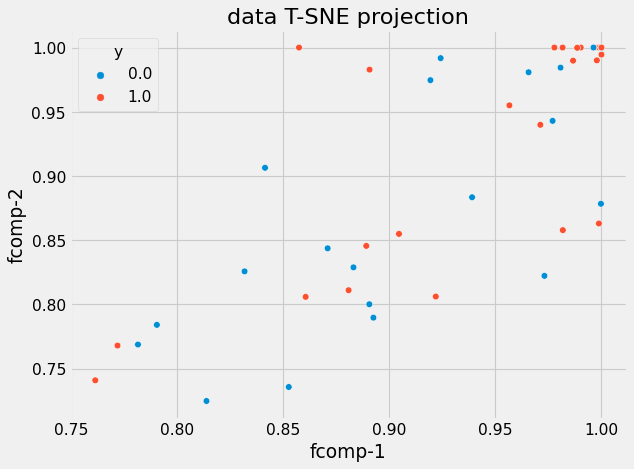

In [882]:

d, o = totalData.values, labels_level1.flatten()

tsne = TSNE(n_components=2, verbose=1, random_state=123) 

z = tsne.fit_transform(d) 

df = pd.DataFrame()
df["y"] = labels_level1
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

df["fcomp-1"] = totalData[WMPS["features"].iloc[10]].values
df["fcomp-2"] = totalData[WMPS["features"].iloc[1]].values


figure(figsize=(8, 6), dpi=80)

sns.scatterplot(x="fcomp-1", y="fcomp-2",hue="y", 
                data=df).set(title="data T-SNE projection") 

In [ ]:
KMeans(n_clusters=2, random_state=0).fit(X_train.values)



## Level- 2 clustering

In [789]:
# NoneedImprovementIndexes = participant_indexes[val_MSE < 20]
# NoneedImprovementPatients = dta.iloc[NoneedImprovementIndexes, :]
# NoneedImprovementPatients

# DBSCAN(eps=6, min_samples=3).fit(X_train)
# KMeans(n_clusters=4, random_state=0, n_init="auto")

# outputs = outputs.values.reshape(-1,1)
n_clusters = 7
mdepth = 5
val_MSE = []
dta  = needImprovementPatients 
kf = KFold(n_splits= len(dta), shuffle=True)
total_scores = []
total_preds = []
total_stds = []
fimportances = []

participant_indexes = []
for i, (train_index, val_index) in enumerate(kf.split(dta)):

        X_train, y_train = dta.iloc[train_index,:], toutputs[train_index]
        X_val, y_val = dta.iloc[val_index,:], toutputs[val_index]
        participant_indexes.append(val_index[0])
                
        prediction = []    
        val_output = []
        stds = []
        feaimportances = []                

        # clustering = GaussianMixture(n_components=n_clusters,tol=1e-5, random_state=0).fit(X_train.values)
        clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X_train.values)

        train_clusters = clustering.predict(X_train)
        prediction_clusters = clustering.predict(X_val)


        for cluster in tqdm(range(n_clusters)):
                regr = RandomForestRegressor(max_depth=mdepth, random_state=0 ) #, max_features = None)
                train_data = X_train[train_clusters==cluster]
                train_outputs = y_train[train_clusters==cluster]   
                
                scaler = MinMaxScaler()
                train_outputs = scaler.fit_transform(train_outputs)
                
                val_data = X_val[prediction_clusters==cluster]
                val_outputs = y_val[prediction_clusters==cluster]
                                
                predictor = RandomForestRegressor(max_depth=4, random_state=0)
                
                
                if len(train_data) >= 1:
                        regr = make_pipeline(StandardScaler(), predictor)
                        regr.fit(train_data, train_outputs.ravel())
                        featimportances = regr["randomforestregressor"].feature_importances_ 
                        features = list(train_data.columns)
                        
                        
                        importances = pd.DataFrame()
                        importances["features"] = features 
                        importances["features MDI importances"] = featimportances
                
                        feaimportances.append(importances)
                
                        std = np.std([tree.feature_importances_ for tree in regr["randomforestregressor"].estimators_], axis=0)
                        stds += [std]
                
                if len(val_data)>=1:
                        val_outputs = scaler.transform(val_outputs)
                        vpreds = regr.predict(val_data)
                        vpreds = vpreds.reshape(len(vpreds),1)
                        vpreds = scaler.inverse_transform(vpreds)
                        prediction += list(vpreds.flatten())
                        
                        vouts = scaler.inverse_transform(val_outputs).flatten()
                        val_output += list(vouts)
                        
        
        total_preds.append(prediction[0])
        total_scores.append(val_output[0])    
        total_stds.append(stds)
        fimportances.append(feaimportances)
        val_MSE.append(mean_squared_error(prediction, val_output, squared=False))
        

print("validation MSEs are ")
print(val_MSE)    

100%|██████████| 7/7 [00:00<00:00, 14.71it/s]

validation MSEs are 
[21.93499999999996, 3.5120000000000218, 43.643, 24.095999999999997, 12.577000000000027, 19.977999999999977, 45.58699999999996, 29.637, 20.835999999999984, 27.64300000000003, 40.223000000000006, 2.937000000000012, 14.725000000000009, 23.00700000000001, 30.591, 21.61099999999999, 37.34600000000002, 37.82599999999999, 32.85500000000002, 27.096000000000004, 3.670999999999964, 7.266999999999989, 52.92999999999998, 28.618000000000002, 32.29700000000001, 44.57200000000002, 5.819000000000003, 27.405000000000015, 22.06700000000003]


In [790]:
val_MSE = np.array(val_MSE)
# < 10 - 25
# 10 > , < 20 - 10
# > 20 - 20

print("Grey Matter < 10 = ", len(val_MSE[val_MSE <= 10]), " -- mean = ", np.mean(val_MSE[val_MSE <= 10]))

temp = val_MSE[val_MSE < 20]
temp = temp[temp > 10 ]
print("Grey Matter between 10, 20 = ",len(temp), " --- mean = ", np.mean(temp))

print("Grey Matter > 20 = ",len(val_MSE[val_MSE > 20]), "  -- mean = ", np.mean(val_MSE[val_MSE > 20]))

GM_scores = np.array(total_scores)
GM_preds = np.array(total_preds)

print(GM_scores[val_MSE > 30])
print(GM_preds[val_MSE > 30])

Grey Matter < 10 =  5  -- mean =  4.641199999999998
Grey Matter between 10, 20 =  3  --- mean =  15.760000000000005
Grey Matter > 20 =  21   -- mean =  31.99147619047619
[74.1 13.  89.  76.2 66.6 97.  88.9 28.9 92.  11.7]
[30.457 58.587 48.777 45.609 29.254 59.174 56.045 81.83  59.703 56.272]


### Level 3 Clustering

## Feature Importances

# Clustering Part

In [610]:
print(val_MSE[val_MSE > 40])

[49.01709286 41.43028333 40.43001905 45.44916667]


In [429]:
val_MSE = np.array(val_MSE)

#17 
val_MSE[val_MSE < 9.6] 

# 9
val_MSE = val_MSE[val_MSE < 20] 
len(val_MSE[val_MSE > 10])

9

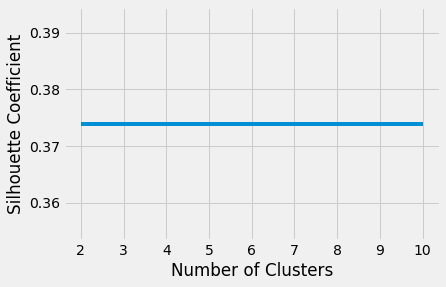

array([3, 0, 2, 0, 2, 0, 3, 3, 1, 2, 1, 1, 0, 0, 1, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 1, 0, 1, 1, 1, 3, 2, 0, 3, 1, 2, 1, 2, 3, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 3], dtype=int32)

In [392]:
silhouette_coefficients = []

kmeans_kwargs= {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}

for k in range(2, 11):
    # kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans = KMeans(n_clusters=4, random_state=0)
    kmeans.fit(X_train[important_columns[:2]].values)
    cls = kmeans.predict(X_train[important_columns[:2]])
    score = silhouette_score(X_train[important_columns[:2]], cls) #kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()


In [ ]:
c = GaussianMixture(n_components=10, tol=1e-5, random_state=0)
# X_train.values.astype(float)
c.fit(X_train.values)
cls = c.predict(X_train)
cls 

In [562]:
outputs.flatten()

<AxesSubplot:xlabel='columns'>

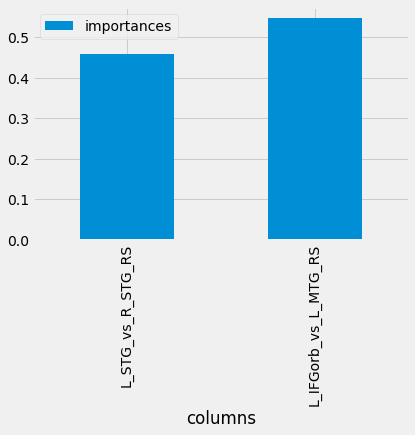

<AxesSubplot:xlabel='columns'>

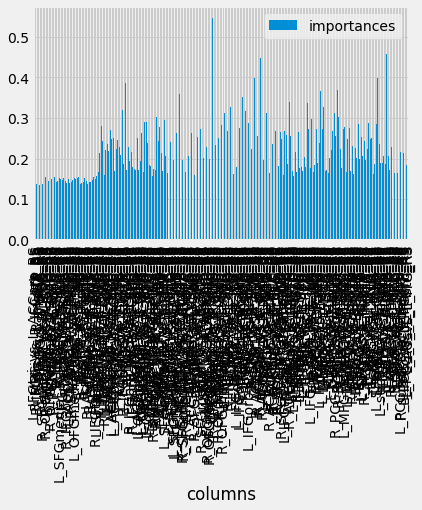

In [563]:
dta = RS
outputs = np.array(outputs)
outputs = outputs.reshape(outputs.shape[0], 1)
num_features = 250

all_features = np.array(RS.columns)
data = np.hstack((dta.values, outputs))
data = pd.DataFrame(data)

corrs = data.corr().abs()
corrs = corrs.fillna(0)
importances = corrs.values[-1][:-1]

top_columns = np.argpartition(importances, -num_features)[-num_features:]

important_columns = all_features[top_columns]
important_columns = list(important_columns)

imps = importances[top_columns]

cf = {
    "columns" : important_columns,
    "importances" : imps
}

cf = pd.DataFrame(cf)

cf.plot.bar(x = "columns", y = "importances")

[t-SNE] Computing 53 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 1.992834
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.900684
[t-SNE] KL divergence after 1000 iterations: 0.607904


[Text(0.5, 1.0, 'data T-SNE projection')]

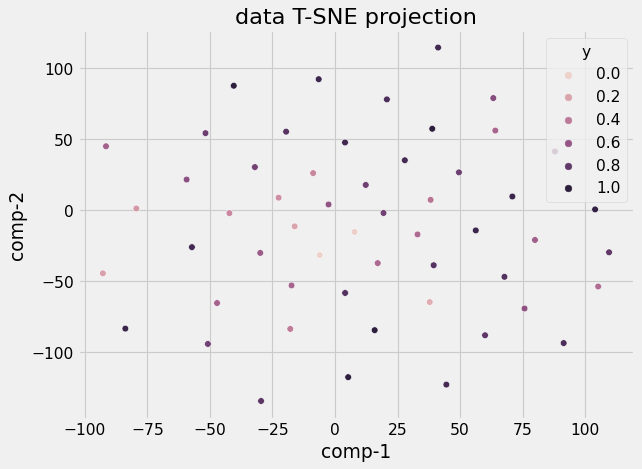

In [565]:

d, o = X_train.values, y_train.flatten()

tsne = TSNE(n_components=2, verbose=1, random_state=123)
pca = PCA(n_components=2) 

z = tsne.fit_transform(d) 
z1 = pca.fit_transform(d) 

# z = d


# f, ax = plt.subplots(1,2, constrained_layout = True)
df = pd.DataFrame()
df["y"] = o
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["pcomp-1"] = z1[:,0]
df["pcomp-2"] = z1[:,1]

figure(figsize=(8, 6), dpi=80)
# plt.plot()

sns.scatterplot(x="comp-1", y="comp-2",hue="y", 
                data=df).set(title="data T-SNE projection") 


In [566]:
temp_train = y_train

num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  8  -- deviation =  0.019   --- scores  dev =   0.194
num scores =  5  -- deviation =  0.061   --- scores  dev =   0.323
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  22  -- deviation =  0.035   --- scores  dev =   0.274
num scores =  3  -- deviation =  0.035   --- scores  dev =   0.029
num scores =  7  -- deviation =  0.027   --- scores  dev =   0.15
num scores =  3  -- deviation =  0.007   --- scores  dev =   0.166
num scores =  3  -- deviation =  0.007   --- scores  dev =   0.313


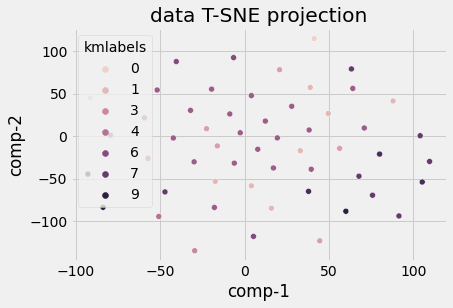

In [567]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_train[important_columns].values)
df["kmlabels"] = kmeans.labels_
sns.scatterplot(x="comp-1", y="comp-2",hue="kmlabels", 
                data=df).set(title="data T-SNE projection") 

# y_train[kmeans.labels_ == 1]
x_axis = []
y_axis = []

y_train = temp_train 
y_train = scaler.fit_transform(y_train)
scaler.fit_transform(y_train)

for cluster in np.unique(kmeans.labels_):
    fildata = X_train[kmeans.labels_== cluster][important_columns[1]].values
    filouts = y_train[kmeans.labels_ == cluster]
    x_axis.append(np.var(fildata))
    y_axis.append(np.std(filouts.flatten()))
    print("num scores = ",len(filouts.flatten())," -- deviation = ", round(np.var(fildata), 3),  "  --- scores  dev =  ", round(np.std(filouts.flatten()), 3) )
    

[Text(0.5, 1.0, 'data T-SNE projection')]

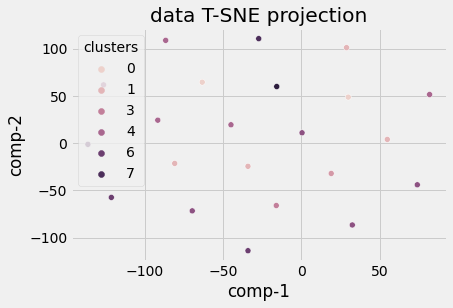

In [552]:
cluster_patients = X_train[kmeans.labels_==5][important_columns[:2]]
cluster_outs = y_train[kmeans.labels_==5]

kmeans2 = KMeans(n_clusters=9, random_state=0)
kmeans2.fit(cluster_patients.values)

# cluster_outs[kmeans2.labels_ == 1]

tsne2 = TSNE(n_components=2, verbose=0, random_state=123)
z2 = tsne2.fit_transform(cluster_patients.values) 

df = pd.DataFrame()
df["y"] = cluster_outs.flatten()
df["clusters"] = kmeans2.labels_ 
df["comp-1"] = z2[:,0]
df["comp-2"] = z2[:,1]

sns.scatterplot(x="comp-1", y="comp-2",hue="clusters", 
                data=df).set(title="data T-SNE projection") 

In [553]:
for cluster in np.unique(kmeans2.labels_):
    fildata = cluster_patients[kmeans2.labels_== cluster][important_columns[1]].values
    filouts = cluster_outs[kmeans2.labels_ == cluster]
    x_axis.append(np.var(fildata))
    y_axis.append(np.std(filouts.flatten()))
    print("num scores = ",len(filouts.flatten())," -- deviation = ", round(np.var(fildata), 3),  "  --- scores  dev =  ", round(np.std(filouts.flatten()), 3) )    

num scores =  2  -- deviation =  0.001   --- scores  dev =   0.083
num scores =  4  -- deviation =  0.001   --- scores  dev =   0.189
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  5  -- deviation =  0.002   --- scores  dev =   0.244
num scores =  4  -- deviation =  0.0   --- scores  dev =   0.22
num scores =  3  -- deviation =  0.0   --- scores  dev =   0.088
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0
num scores =  1  -- deviation =  0.0   --- scores  dev =   0.0


<BarContainer object of 55 artists>

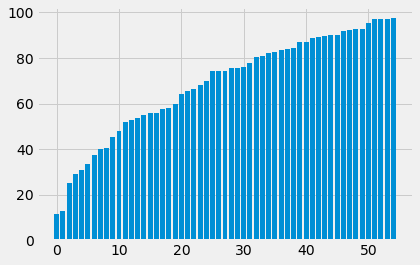

In [325]:
plt.bar(list(range(55)), sorted(outputs.flatten()))

array([[0.87995338],
       [0.15734266],
       [0.46969697],
       [0.72727273],
       [0.22261072],
       [0.63986014],
       [0.42307692],
       [0.82867133],
       [0.97319347],
       [0.8006993 ],
       [0.93706294],
       [0.32983683],
       [0.94405594],
       [0.61421911],
       [0.87995338],
       [0.25524476],
       [0.72960373],
       [0.77272727],
       [0.2004662 ],
       [0.01515152],
       [0.        ],
       [0.62587413],
       [0.39044289],
       [0.33449883],
       [0.3006993 ],
       [0.53962704],
       [0.84615385],
       [0.51631702],
       [0.91375291],
       [0.56293706],
       [0.90675991],
       [0.84265734],
       [0.81934732],
       [0.8997669 ],
       [0.94522145],
       [0.80652681],
       [0.53496503],
       [0.75174825],
       [0.65734266],
       [0.93589744],
       [0.91491841],
       [0.50699301],
       [1.        ],
       [0.99417249],
       [0.99417249],
       [0.995338  ],
       [0.67599068],
       [0.839

<BarContainer object of 55 artists>

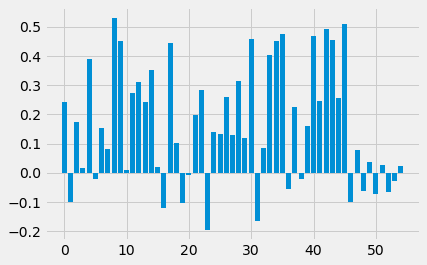

In [327]:
plt.bar(list(range(55)),RS[important_columns[0]])

In [214]:
dta = GM
for patient in range(55):
    pdata = dta.iloc[patient, :].values 
    poutput = outputs[patient]
    temp = list(range(55))
    temp.remove(patient)
    restdata = dta #.iloc[temp, :]
    
minnum = 5 

print("score = ", poutput)
dists = np.linalg.norm(pdata - restdata.values, axis=1)
for i in range(minnum):
    dists[np.argmin(dists)] = 10
    print(" i -- nearest  = ", outputs[np.argmin(dists)])


score =  56.0
 i -- nearest  =  37.5
 i -- nearest  =  82.8
 i -- nearest  =  30.8
 i -- nearest  =  56.0
 i -- nearest  =  74.3
